**Algerian Forest Fires - When Are You At Risk?**

**Introduction** 

A forest fire is the uncontrolled burning of plants in a natural setting such as a forest, that consumes natural fuels and spreads based on environmental conditions (“Forest Fires”, 2021). These fires can be caused by human actions, extreme drought, or lightning, and can have devastating effects on the environment and human life (“Forest Fires”, 2021). Some countries, such as Algeria, have higher instances of forest fires, as they have longer dry seasons and often lack the infrastructure to control such large fires (Meddour-Sahar, 2015). As such, predicting the onset of forest fires in these regions plays an integral role in the mitigation of this threat. 

For our project, we will predict when forest fires in Algeria will occur in the future, based on weather components. In particular, we want to know, “Under which weather conditions, considering relative humidity and temperature, are forest fires more likely to occur in the Bejaia region?” We will investigate this prediction by using the Algerian Forest Fires Dataset, which contains data from two regions of Algeria, but we will focus only on the Bejaia region in order to work with a more manageable data set. There are 11 total variables in this dataset, of which we will use Temperature and Humidity, as we expect these variables to have a significant effect on the the liklihood of forest fires taking place, and using only two variables aligns more with what we have covered in class. There are 122 total observations and the period of data collection is from June of 2012 to September of 2012.

**Preliminary Exploratory Data Analysis**

In [5]:
#load libraries
library(readxl)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [6]:
download.file(url, destfile = "data/Algerian_forest_fires_dataset_UPDATE.csv")

In [7]:
#read data
bejaia_basic <- read_csv(file = "data/Algerian_forest_fires_dataset_UPDATE.csv", skip=1, n_max=122) %>%
mutate(Classes=as_factor(Classes))

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)



In [8]:
#tidy data
bejaia_with_date <- tidyr::unite(bejaia_basic, "Date", year, month, day, remove = FALSE,sep = "-" ) #combine year, month and day to make date
bejaia_tidy <- select(bejaia_with_date, Date, month, Temperature, RH, Ws, Rain, Classes) #select only variables we will be using

In [9]:
#create the train/test split
set.seed(1) #set seed in order to make code reproducible and ensure that it generates the same train/test split each time
bejaia_split <- initial_split(bejaia_tidy, prop=0.75, strata=Classes) #create 75/25 train/test split to train an accurate model + get an accurate evaluation
bejaia_train <- training(bejaia_split)
bejaia_test <- training (bejaia_split)
glimpse(bejaia_train)

Rows: 93
Columns: 7
$ Date        <chr> "2012-06-01", "2012-06-02", "2012-06-03", "2012-06-04", "…
$ month       <chr> "06", "06", "06", "06", "06", "06", "06", "06", "06", "06…
$ Temperature <dbl> 29, 29, 26, 25, 27, 33, 30, 25, 26, 27, 29, 30, 31, 31, 3…
$ RH          <dbl> 57, 61, 82, 89, 77, 54, 73, 88, 81, 84, 89, 89, 78, 55, 7…
$ Ws          <dbl> 18, 13, 22, 13, 16, 13, 15, 13, 19, 21, 13, 16, 14, 16, 1…
$ Rain        <dbl> 0.0, 1.3, 13.1, 2.5, 0.0, 0.0, 0.0, 0.2, 0.0, 1.2, 0.7, 0…
$ Classes     <fct> not fire, not fire, not fire, not fire, not fire, fire, f…


In [10]:
#summarize training data in a table
num_obs <- nrow(bejaia_train)
bejaia_train %>% group_by(Classes) %>% summarize(n=n(), percentage = n()/num_obs*100)

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n,percentage
<fct>,<int>,<dbl>
not fire,48,51.6129
fire,45,48.3871


The next two visualizations help us compare the distribution of our variables, Temperature and Relative Humidity. We used a bar chart for this because we are comparing a categorical variable - months - to a continuous variable - either temperature or humidity. A bar chart allows us to easily observe how temperature and humidity have changed each month, which can help us by seeing which conditions are more common in which months.

`summarise()` ungrouping output (override with `.groups` argument)



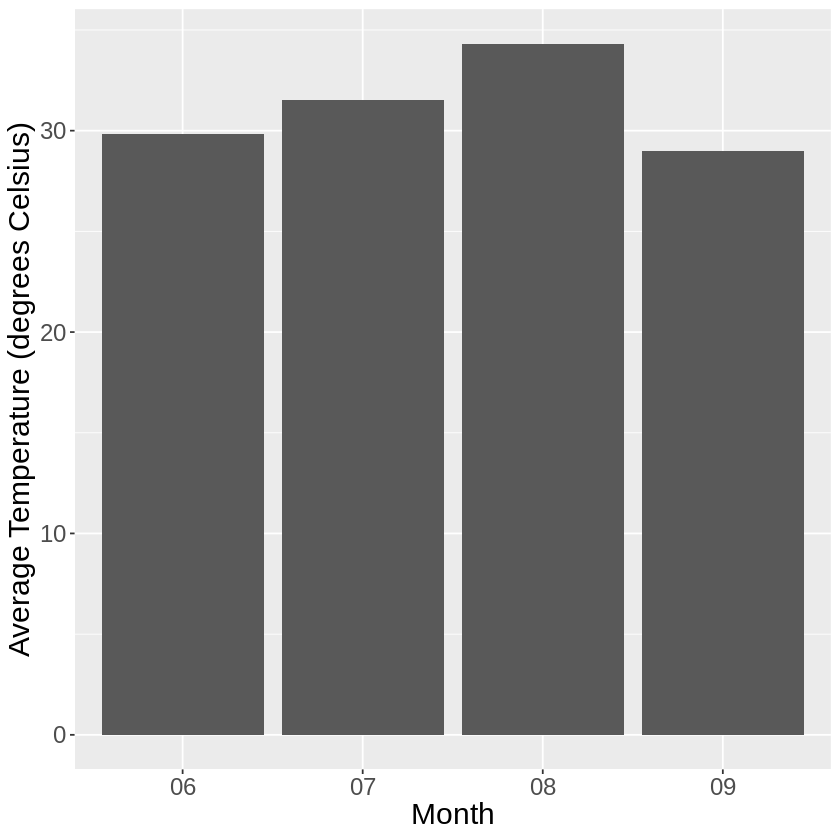

In [18]:
#use training data to make a visualization comparing distribution of Temperature
bejaia_average_1 <- bejaia_train %>% 
    group_by(month) %>% 
    summarize(Temperature = mean(Temperature, na.rm = TRUE)) #average daily temperatures to get an average temperature for each month

bejaia_graph_1 <- ggplot(bejaia_average_1, aes(x=month, y=Temperature))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Average Temperature (degrees Celsius)")+
theme(text = element_text(size = 18))
bejaia_graph_1

This chart shows that the months of June and September have the the lowest average temperature, and august having the highest temperature - if we were only using this variable we might say that fires are more likely to occur in August due to the higher temperature.

`summarise()` ungrouping output (override with `.groups` argument)



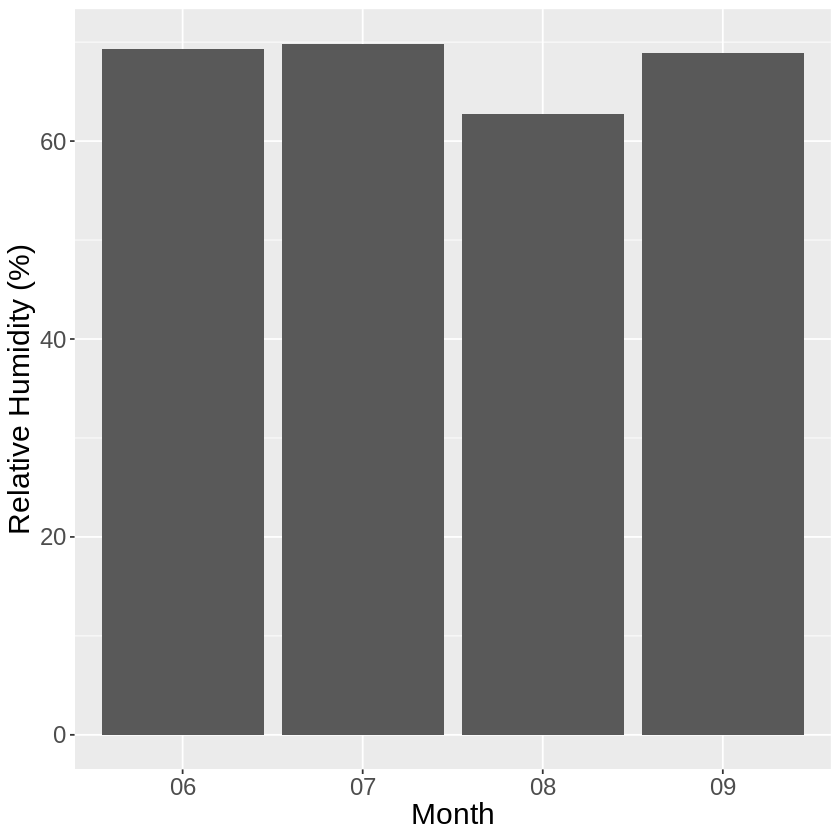

In [17]:
#use training data to make a visualization comparing distribution of Relative Humidity
bejaia_average_2 <- bejaia_train %>% 
    group_by(month) %>% 
    summarize(RH = mean(RH, na.rm = TRUE)) #average daily relative humidity to get an average RH for each month

bejaia_graph_2 <- ggplot(bejaia_average_2, aes(x=month, y=RH))+
geom_bar(stat = "identity")+
xlab("Month")+
ylab("Relative Humidity (%)")+
theme(text = element_text(size = 18))
bejaia_graph_2

The plot shows us that August has the lowest relative humidity and July has the highest, with June and September only marginally lower. Only looking at relative humidity, it seems that August would have the most fires. 


Looking at both graphs, the month of August not only has the highest temperature, but also has the lowest relative humidity - meaning that using these two predictors fires are more likely to occur in August. 

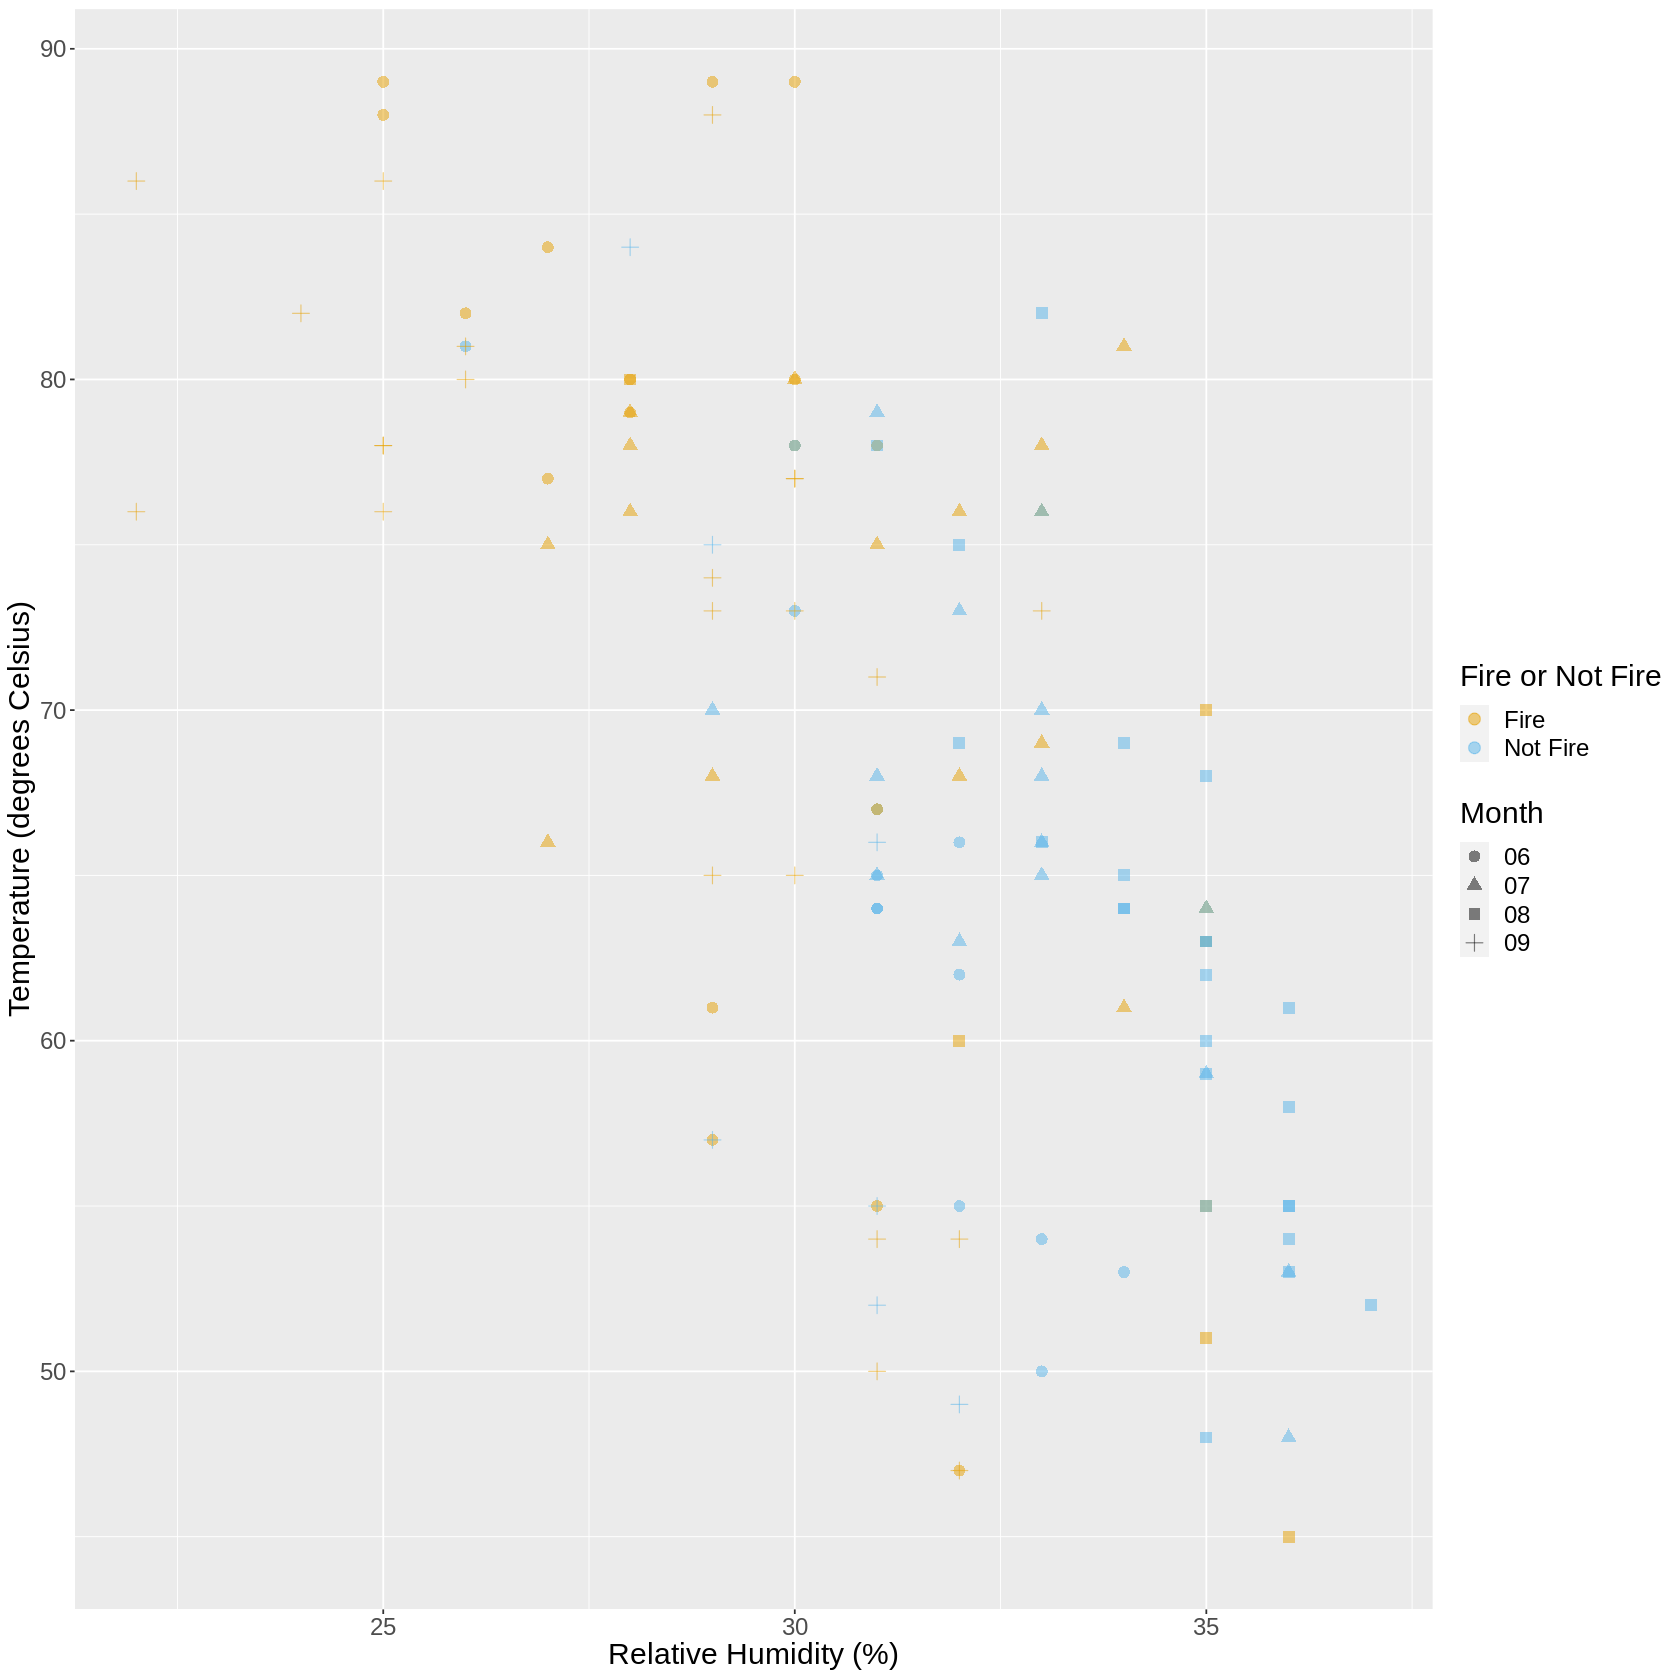

In [28]:
#Create a scatterplot to visualize the relationship between our two variables, Temperature and Relative Humidity

cbPalette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999")
options(repr.plot.width = 14, repr.plot.height = 14)
fire_plot <- bejaia_tidy %>%
ggplot(aes(x = Temperature, y = RH, color = Classes, shape = month)) +
geom_point(alpha = 0.5, size = 3) +
labs(x="Relative Humidity (%)", y= "Temperature (degrees Celsius)", color = "Fire or Not Fire", shape = "Month") +
scale_color_manual(labels = c("Fire", "Not Fire"), values = cbPalette) +
theme(text = element_text(size = 18))
fire_plot

**Methods**

For our data analysis, we will use weather data observations, including the variables Relative Humidity (RH) and Temperature to predict when forest fires are more likely to occur in the Bejaia region. We omitted the variables from the FWI components, which are derived from the weather data observations. To answer our question, we will use these variables to perform classification and predict when forest fires are more likely to occur. 


In [13]:
#preprocess data
fire_recipe <- recipe(Classes ~ Temperature, RH, data = bejaia_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

In [14]:
#train the classifier
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(fire_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = bejaia_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3655914
Best kernel: rectangular
Best k: 3

In [15]:
#Predict the labels in the test set
fire_test_predictions <- predict(knn_fit, bejaia_test) %>%
  bind_cols(bejaia_test)
fire_test_predictions

.pred_class,Date,month,Temperature,RH,Ws,Rain,Classes
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,2012-06-01,06,29,57,18,0.0,not fire
not fire,2012-06-02,06,29,61,13,1.3,not fire
not fire,2012-06-03,06,26,82,22,13.1,not fire
not fire,2012-06-04,06,25,89,13,2.5,not fire
not fire,2012-06-05,06,27,77,16,0.0,not fire
fire,2012-06-07,06,33,54,13,0.0,fire
fire,2012-06-08,06,30,73,15,0.0,fire
not fire,2012-06-09,06,25,88,13,0.2,not fire
not fire,2012-06-12,06,26,81,19,0.0,fire


In [16]:
#compute the accuracy
fire_test_predictions %>%
  metrics(truth = Classes, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6344086
kap,binary,0.2690707


**Expected Outcomes and Signficance**

We hope to predict when forest fires are more likely to occur by observing weather conditions. We expect that forest fires will be more likely at lower relative humidity, higher temperatures. 

These findings could help residents recognize forest fire conditions, which could result in less damage to property and fewer casualties. For example, during high-risk conditions, civilians may prepare for forest fires by creating emergency kits in case of evacuation, or farmers may trim lawns and tall vegetation to minimize damage (Weir, 2018). 

This data could lead to future questions, such as how the likelihood of forest fires differs between regions of Algeria. Taking data from other regions could help us better understand how climate conditions differ across Algeria, and how this variation in conditions affects the likelihood of forest fires. 
